In [1]:
import pandas as pd
df=pd.read_csv("../data/fake_and_real_news_final_.csv")

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

df = df.sample(frac=1)
df = df.dropna(subset=['clean_text', 'label'])
vectorizer_text=CountVectorizer()
bag_of_words_text=vectorizer_text.fit_transform(df['text'])
bag_of_words_clean_text=vectorizer_text.fit_transform(df['clean_text'])
bag_of_words_clean_text_lower=vectorizer_text.fit_transform(df['clean_text_lower'])

print(bag_of_words_text.shape)
print(bag_of_words_clean_text.shape)
print(bag_of_words_clean_text_lower.shape)

(43976, 121945)
(43976, 97354)
(43976, 97354)


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df = df.sample(frac=1)
df = df.dropna(subset=['clean_text_lower', 'label'])

X = df["clean_text_lower"]
y = df["label"]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(2,3), min_df=15, max_df=0.7)),
    ('multinomialnb', MultinomialNB(alpha=1))
])


pipeline.fit(X_train, y_train)


y_pred= pipeline.predict(X_test)
y_pred_train= pipeline.predict(X_train)


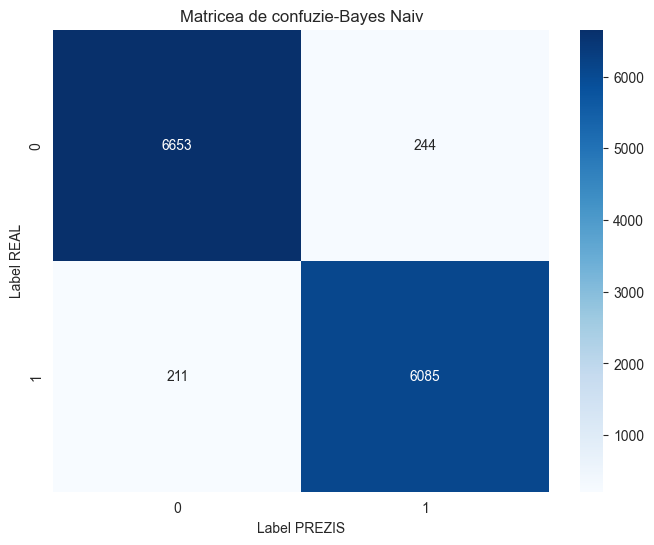

In [4]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matricea de confuzie-Bayes Naiv')
plt.xlabel('Label PREZIS')
plt.ylabel('Label REAL')
plt.show()

In [5]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred,target_names=['Fake', 'Real'])
print("Classification Report (Test):\n", report)

report = classification_report(y_train, y_pred_train,target_names=['Fake', 'Real'])
print("Classification Report (Train):\n", report)

Classification Report (Test):
               precision    recall  f1-score   support

        Fake       0.97      0.96      0.97      6897
        Real       0.96      0.97      0.96      6296

    accuracy                           0.97     13193
   macro avg       0.97      0.97      0.97     13193
weighted avg       0.97      0.97      0.97     13193

Classification Report (Train):
               precision    recall  f1-score   support

        Fake       0.97      0.97      0.97     15869
        Real       0.97      0.97      0.97     14914

    accuracy                           0.97     30783
   macro avg       0.97      0.97      0.97     30783
weighted avg       0.97      0.97      0.97     30783



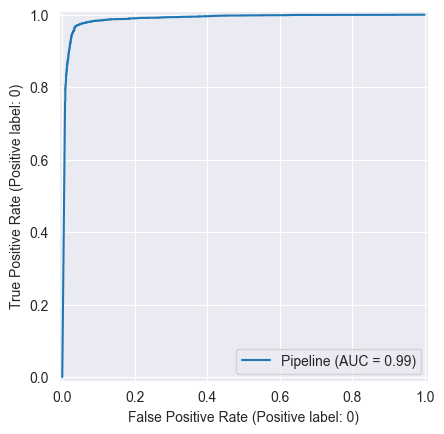

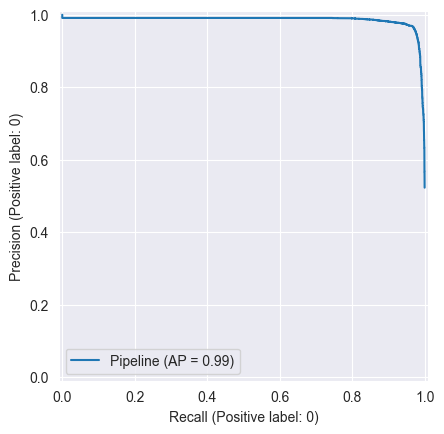

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
nb_display=RocCurveDisplay.from_estimator(pipeline, X_test, y_test,pos_label=0 )
plt.show()

nb_pr=PrecisionRecallDisplay.from_estimator(pipeline,X_test,y_test,pos_label=0)
plt.show()  

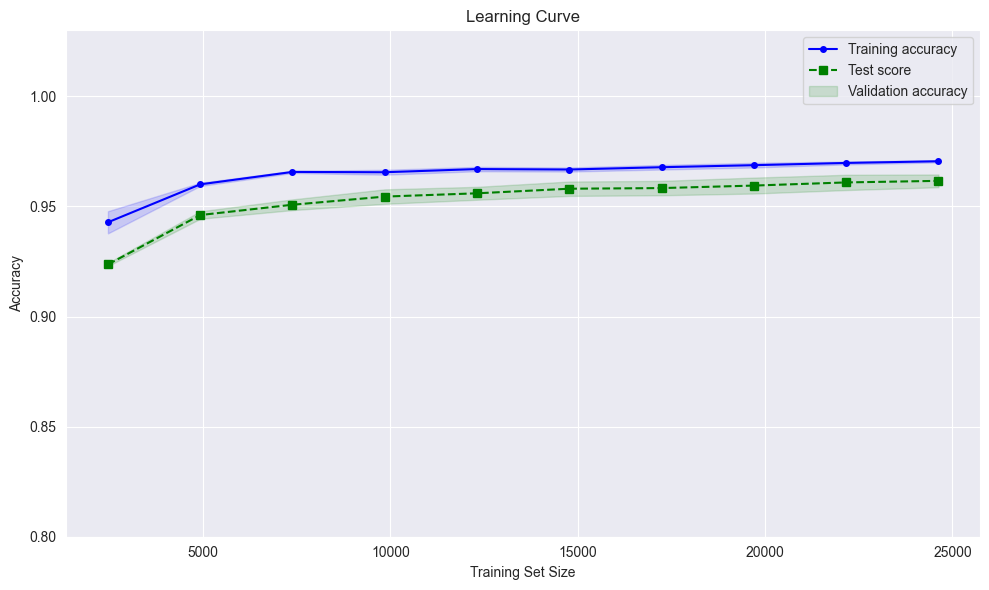

In [7]:
from sklearn.model_selection import learning_curve,train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

testing_pipeline = Pipeline([
    ('countvectorizer', CountVectorizer(ngram_range=(2,3), min_df=15, max_df=0.7)),
    ('multinomialnb', MultinomialNB(alpha=1))
])

X = df["clean_text_lower"].astype(str)
y = df["label"]


X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=testing_pipeline,       
    X=X_train,          
    y=y_train,           
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5,              
    scoring='accuracy', 
    n_jobs=10          
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 6))


plt.plot(train_sizes, train_mean, label="Training accuracy", color='blue', marker='o',markersize='4')
plt.fill_between(train_sizes,
train_mean + train_std,
train_mean - train_std,
alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, label="Test score", color='green',marker='s',linestyle='--')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green',label='Validation accuracy')


plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.ylim([0.8, 1.03])
plt.grid(True)
plt.tight_layout()
plt.show()0

In [8]:
import joblib
joblib.dump(pipeline, './news_classifier_pipeline_naive_bayes.pkl')

['./news_classifier_pipeline_naive_bayes.pkl']